# Creating Adversarial Images

The paper [Adversarial Machine Learning in Image Classification](https://dl.acm.org/doi/pdf/10.1145/3485133?casa_token=dKsj5CyofT4AAAAA:5ZuX5-w44St-o_HrKfkqgh6WxtE0R2Z29LgVSNSd-flziEX-F3j8PSQKEEzSB-7aNtJDOpZXX7XU) explains many of the concepts within the area of adversarial attacks in image classification.

Firstly, this is the general approach that is applied to an image to create an adversarial image.

Say we represent an image classification model by $f$ and an image it takes as input by $x$. Then the classification model is essentially a map $x \mapsto f(x)$. For each image $x$, a new image $x'=x+ \delta x$ can be created such that $f(x) \neq f(x')$, i.e. the classification has changed. This alteration $ \delta x$ is know as a perturbation. 

There are many things to consider when creating an adversarial attack. 

### Pertubation Scope
Pertubations can either be individual-scoped or universal-scoped. Invidual-scoped means that the perturbation generated is dependent on the input image; universal-scoped means it is not.

### Visibility of Perturbations
Perturbations can be categorised on the most basic level into indistinguishable or visible. Indistinguishable means that the perturbation was too small to fool the neural network, and it would not be visible to humans either. Visible means that the neural network was fooled but the perturbation is noticeable to humans. An extreme of this is called 'fooling' and means the image would be unrecoginsable as the original to a human. Somewhere there is an optimal perturbation that leads to misclassification but would not be noticed by a human. 

### Types of Attack

#### Attacker's Influence
There may be cases in which the attacker has access to the training of the model in some way, in which case they can control the output of the classification to some extent by what the model is trained on. We will assume that this was not the case in our project.

#### Attacker's Knowledge
There are a few types of attack that are often tested against when reviewing the robustness of a model: white-box attacks, black-box attacks and grey-box attacks. White-box means that the attacker knows what classification model is used in its entirety, as well as its defenses to adversarial attacks. Black-box means that the attacker has no knowledge of the model or its defenses, although it is usually assumed that the attacker is able to query the model in large quantities. Grey-box means that the attacker has knowledge of the model but not of its defenses.

In this project we will look into both black-box attacks and grey-box attacks. We will not look into making new attacks based on the defenses we produce.

#### Attack Specificity 
Some attacks might try to produce a specific misclassification, whereas some are just looking to achieve any misclassification. Due to time restraints, we will not look into producing certain misclassifications, even though it could be something of interest to look into.

### Our Approach
By considering the specific hypothetical problem of pysical adversarial alterations being made to road signs in order to impact driverless cars, we both narrow the problem down as well as introduce new practicality issues. There are many ways in which adversarial images are created, many of which would probably not have much application to this setting, such as changes to colour, blurring, rotation, and effects on the shape. We will therefore only consider perturbations which could correspond to something that could be stuck on to a road sign.

It would be the most likely case in our real-world application that the attacker would not have access to internal information regarding the model, so we begin by considering that case. We mentioned previously that with black-box attacks, it is generally assumed that the attacker can query the model many times, but that would probably not be the case with this application. To query the model, a physical sign would have to be shown to a car, which would be very time consuming.

So, firstly we will look at adversarial image generation techniques that do not take into account the model. Our approach will be to add in random noise and occlusions. Random noise refers changing the pixels randomly to make small changes to the image. An example is Gaussian noise, which is when a random amount (drawn from a Gaussian distribution) of colour and brightness change is added to each pixel. Occulusions refer to blocking off part of the image; this may be with a blank shape or could be another object.

#### Gaussian Noise
To add gaussian noise to an image, we add a gaussian random sample to the red, blue, and green parameters of each pixel.

In [1]:
import numpy as np
import pandas as pd
np.random.seed(1)
#!pip3 install opencv-python
import cv2 as cv
import matplotlib.pyplot as plt
#C&W attack
import tensorflow as tf
#!pip3 install cleverhans
from cleverhans.tf2.attacks import carlini_wagner_l2

In [14]:
img = cv.imread("cat.png")  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

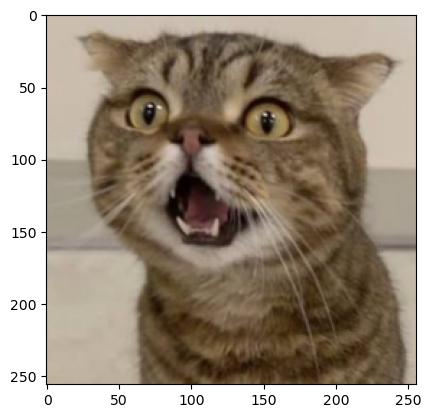

In [15]:
plt.imshow(img)

In [16]:
#https://www.kaggle.com/code/basu369victor/low-light-image-enhancement-with-cnn#IMAGE-WITH-NOISE(SALT-AND-PEPPER-NOISE)
row,col,ch= img.shape
mean = 0
sigma = 30
gauss = np.random.normal(mean,sigma,(row,col,ch))
noisy = cv.add(img.astype(np.int16),gauss.astype(np.int16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


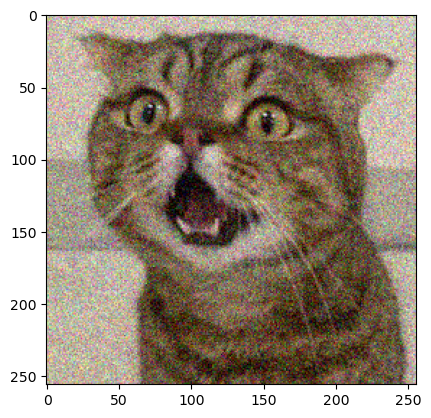

In [17]:
plt.imshow(noisy)

#### Occlusions
For the occlusions, we want to add random numbers of patches to each image. We will make the patches either block colours or segments of other images. We would like the patches to be of random size and random colour/part of other images. Remembering the impact of visibility, especially in our application, it is important that the size and number of the occlusions are not too big to be particularly noticable to humans. Therefore, we will use a poisson distribution with mean 1 to choose the number of occlusions, and a poisson distribution with mean lambda each to choose the height and width of the occlusion.

The position of the occlusion is chosen by uniformly choosing the starting point from the top and from the left of the image.

In [18]:
#Generate number of occlusions.
number = np.random.poisson(1/2) + 1
print(number)

1


In [19]:
#Generate heights and widths (image 256x256 so lambda=50).
def rand_hs_ws(number,mean_size):
    heights=[]
    widths=[]
    for i in range(number):
        heights.append(np.random.poisson(mean_size))
        widths.append(np.random.poisson(mean_size))
    return heights, widths 

In [20]:
hs, ws = rand_hs_ws(number,50)
print(hs)
print(ws)

[52]
[49]


In [21]:
#Generate where they will go on the image.
def rand_locations(number, heights, widths,img_size):
    location_heights=[]
    location_widths=[]
    for i in range(number):
        location_heights.append(np.random.randint(0,img_size-heights[i]+1))
        location_widths.append(np.random.randint(0,img_size-widths[i]+1))
    return location_heights, location_widths

In [22]:
location_hs, location_ws = rand_locations(number, hs, ws, 256)
print(location_hs)
print(location_ws)

[6]
[69]


#### Colour Blocks

In [25]:
for i in range(number):
    colour = np.random.randint(0, 256, size=3)
    img[location_hs[i]:location_hs[i]+hs[i], location_ws[i]:location_ws[i]+ws[i]] = colour

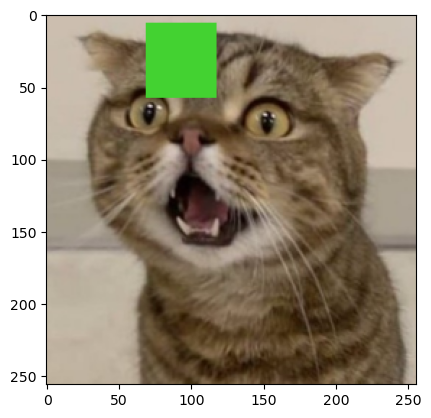

In [26]:
plt.imshow(img)

#### Parts of Other Images
So we have an image that is the same size but different, I'll invert the colours of the cat. This is just to demonstrate.

In [27]:
img = cv.imread("cat.png")  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [28]:
b, g, r = cv.split(img)

inverted_b = 255 - b
inverted_g = 255 - g
inverted_r = 255 - r

inverted_img = cv.merge((inverted_b, inverted_g, inverted_r))

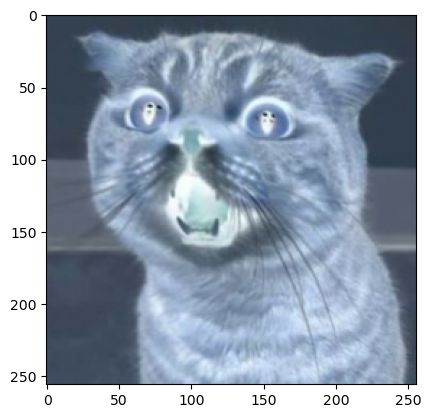

In [29]:
plt.imshow(inverted_img)

In [32]:
hs, ws = rand_hs_ws(number,50)
location_hs, location_ws = rand_locations(number, hs, ws, 256)
source_location_hs, source_location_ws = rand_locations(number, hs, ws, 256)

In [33]:
#get patches to put on
patches=[]
for i in range(number):
    patches.append(inverted_img[source_location_hs[i]:source_location_hs[i]+hs[i], source_location_ws[i]:source_location_ws[i]+ws[i]])

In [34]:
for i in range(number):
    patch = patches[i]
    img[location_hs[i]:location_hs[i]+hs[i], location_ws[i]:location_ws[i]+ws[i]] = patch

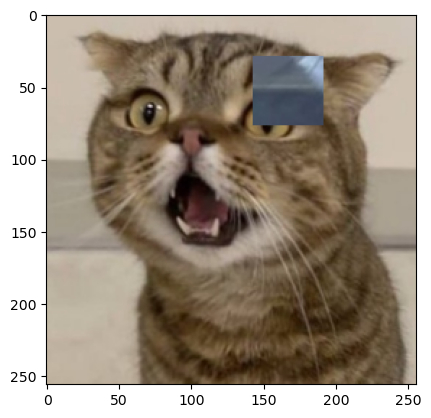

In [35]:
plt.imshow(img)

Now we try the white box attack

In [73]:
# Load the trained model
model = tf.keras.models.load_model('model.h5')

In [74]:
def model_fn(x):
    return model(x)

In [76]:
attack = carlini_wagner_l2.CarliniWagnerL2(model_fn)

In [77]:
# Load the test image
image = tf.keras.preprocessing.image.load_img('Test/00001.png', target_size=(30, 30))
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0

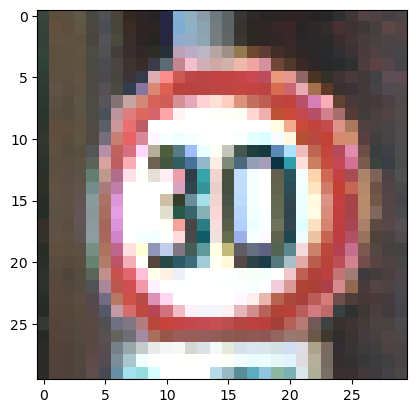

In [78]:
plt.imshow(image)

In [79]:
image_batch = np.expand_dims(image, axis=0)  # Reshape image to have a batch size of 1


In [80]:
adv_image_batch = attack.attack(image_batch)  # Use the attack to generate the adversarial image


In [81]:
adv_image = adv_image_batch[0]  # Remove the batch size dimension to get the adversarial image

In [82]:
# Check if the model misclassifies the adversarial example
adv_prediction = model.predict(tf.expand_dims(adv_image, axis=0))

1/1 [==============================] - 0s 41ms/step


In [83]:
adv_class = tf.argmax(adv_prediction[0])

In [84]:
print(adv_class)

#seems to have output 35 when it should be 16 so that's good?

tf.Tensor(21, shape=(), dtype=int64)


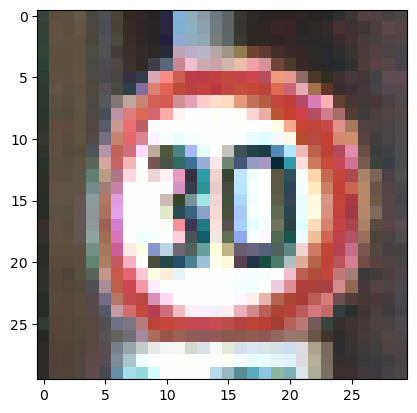

In [86]:
plt.imshow(adv_image)


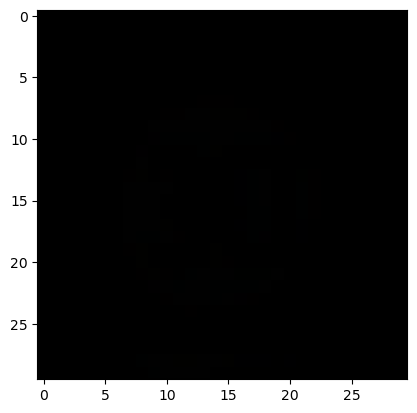

In [88]:
diff=cv.subtract(image.astype(np.int16),adv_image.astype(np.int16))
plt.imshow(diff)

In [92]:
coords = np.argwhere(diff > 0)
print(coords)

[[ 7 13  0]
 [ 7 14  0]
 [ 7 15  0]
 [ 8 10  0]
 [ 8 11  0]
 [ 8 12  0]
 [ 8 12  1]
 [ 8 12  2]
 [ 8 13  0]
 [ 8 13  1]
 [ 8 13  2]
 [ 8 14  0]
 [ 8 14  1]
 [ 8 15  0]
 [ 8 15  1]
 [ 8 16  0]
 [ 8 16  1]
 [ 8 17  0]
 [ 9  9  0]
 [ 9  9  1]
 [ 9  9  2]
 [ 9 10  0]
 [ 9 10  1]
 [ 9 10  2]
 [ 9 11  0]
 [ 9 11  1]
 [ 9 11  2]
 [ 9 12  0]
 [ 9 12  1]
 [ 9 12  2]
 [ 9 13  0]
 [ 9 13  1]
 [ 9 13  2]
 [ 9 14  0]
 [ 9 14  1]
 [ 9 14  2]
 [ 9 15  0]
 [ 9 15  1]
 [ 9 15  2]
 [ 9 16  0]
 [ 9 16  1]
 [ 9 16  2]
 [ 9 17  0]
 [ 9 17  1]
 [ 9 17  2]
 [ 9 18  0]
 [ 9 18  1]
 [ 9 18  2]
 [ 9 19  0]
 [10  9  0]
 [10  9  2]
 [10 10  1]
 [10 10  2]
 [10 11  1]
 [10 11  2]
 [10 12  1]
 [10 12  2]
 [10 13  1]
 [10 13  2]
 [10 14  0]
 [10 14  1]
 [10 14  2]
 [10 15  0]
 [10 15  1]
 [10 15  2]
 [10 16  1]
 [10 16  2]
 [10 17  1]
 [10 17  2]
 [10 18  1]
 [10 18  2]
 [10 19  2]
 [10 20  0]
 [11  8  0]
 [11  8  2]
 [11 13  1]
 [11 13  2]
 [11 14  0]
 [11 14  1]
 [12  8  0]
 [12  8  1]
 [12  8  2]
 [13  7  0]
 [13

In [89]:
prediction = model.predict(tf.expand_dims(image, axis=0))

1/1 [==============================] - 0s 48ms/step


In [90]:
predclass = tf.argmax(prediction[0])
print(predclass)

tf.Tensor(1, shape=(), dtype=int64)


# Add noise to training data

In [4]:
img_array = np.load('array_pixels_training.npy')

Trials to see what levels of noise to add.

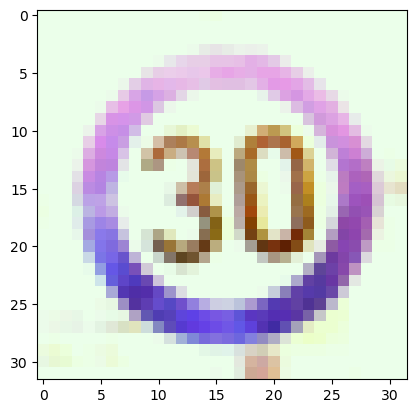

In [30]:
row,col,ch= img_array[0].shape
mean = 0
plt.imshow(img_array[0])

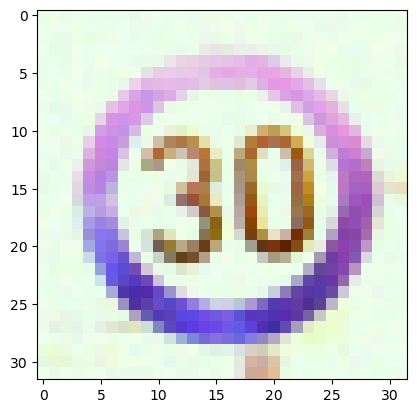

In [35]:
noisy_trial1=cv.add(img_array[0],np.random.normal(mean,0.01,(row,col,ch)))
noisy_trial1 = np.clip(noisy_trial1, 0, 1)
plt.imshow(noisy_trial1)

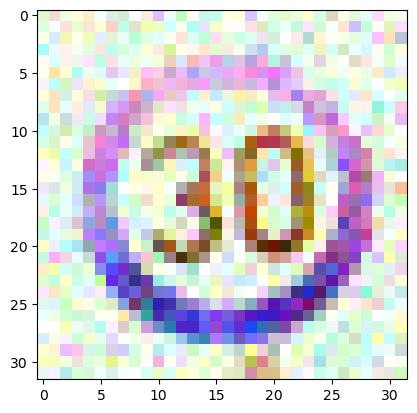

In [37]:
noisy_trial2=cv.add(img_array[0],np.random.normal(mean,0.1,(row,col,ch)))
noisy_trial2 = np.clip(noisy_trial2, 0, 1)
plt.imshow(noisy_trial2)

Seems like reasonable min and max amounts of noise

In [38]:
sigma = np.random.uniform(0.01,0.1,len(img_array))

In [40]:
noisy=np.zeros(img_array.shape) 
for i in range(len(img_array)):
    gauss=np.random.normal(mean,sigma[i],(row,col,ch))
    noisy[i] = np.clip(cv.add(img_array[i],gauss), 0, 1)

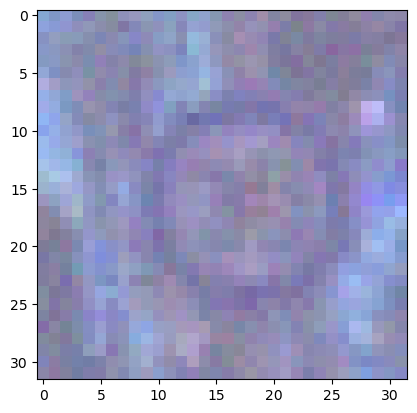

In [41]:
plt.imshow(noisy[9])

In [42]:
np.save('noisy_training.npy', noisy)

# Make training set for adversarial detection classifier
Black

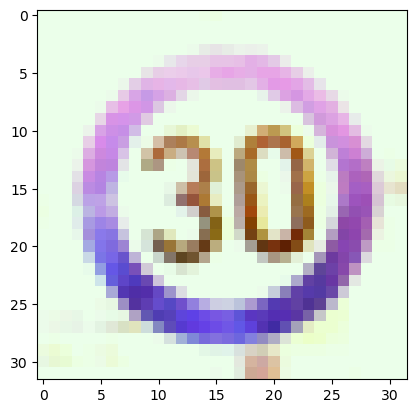

In [36]:
row,col,ch= img_array[0].shape
plt.imshow(img_array[0])

In [50]:
patched = img_array.copy()

In [51]:
for i in range(len(img_array)):
    #Generate number of occlusions.
    number = np.random.poisson(1/2) + 1
    hs, ws = rand_hs_ws(number, 5)
    location_hs, location_ws = rand_locations(number, hs, ws, 32)
    for j in range(number):
        patched[i][location_hs[j]:location_hs[j]+hs[j], location_ws[j]:location_ws[j]+ws[j]] = [0,0,0]
    

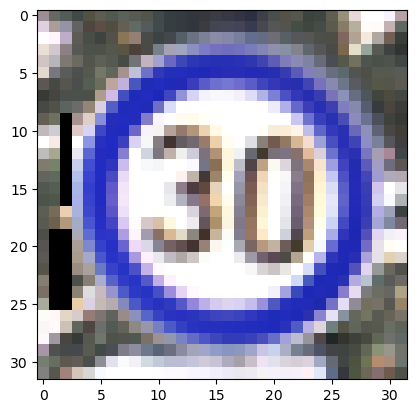

In [59]:
plt.imshow(patched[7])

In [61]:
np.save('black_patched_training.npy', patched)

White

In [75]:
patched_white = img_array.copy()

In [77]:
for i in range(len(img_array)):
    #Generate number of occlusions.
    number = np.random.poisson(1/2) + 1
    hs, ws = rand_hs_ws(number, 5)
    location_hs, location_ws = rand_locations(number, hs, ws, 32)
    for j in range(number):
        patched_white[i][location_hs[j]:location_hs[j]+hs[j], location_ws[j]:location_ws[j]+ws[j]] = [1,1,1]

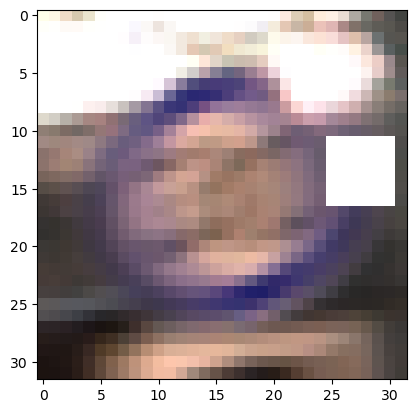

In [82]:
plt.imshow(patched_white[3])

In [83]:
np.save('white_patched_training.npy', patched_white)

pactches are sections of the image

In [62]:
patched2 = img_array.copy()

In [63]:
for i in range(len(img_array)):
    #Generate number of occlusions.
    number = np.random.poisson(1/2) + 1
    hs, ws = rand_hs_ws(number, 5)
    location_hs, location_ws = rand_locations(number, hs, ws, 32)
    source_location_hs, source_location_ws = rand_locations(number, hs, ws, 32)
    patches=[]
    for j in range(number):
        patches.append(patched2[i][source_location_hs[j]:source_location_hs[j]+hs[j], source_location_ws[j]:source_location_ws[j]+ws[j]])
    for j in range(number):
        patched2[i][location_hs[j]:location_hs[j]+hs[j], location_ws[j]:location_ws[j]+ws[j]] = patches[j]

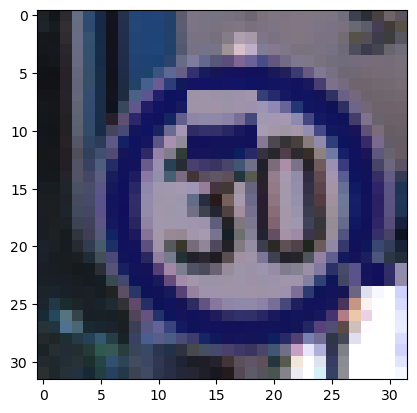

In [71]:
plt.imshow(patched2[6])

In [72]:
np.save('same_image_patched_training.npy', patched2)